In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

# Set plot style and random seed
sns.set(style='ticks', context='talk')
np.random.seed(7)

In [3]:
# Generate synthetic data
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

# Define the true relationship, including a quadratic effect and non-constant noise
beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess) # Noise depends on a predictor
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


In [5]:
# Define features (X) and target (y)
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']

# Split data without shuffling for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the linear regression model
lr = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

In [7]:
# Calculate R-squared and RMSE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Baseline Model --> R² = {r2:.4f} | RMSE = {rmse:.6f}')

Baseline Model --> R² = 0.3677 | RMSE = 0.008470


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


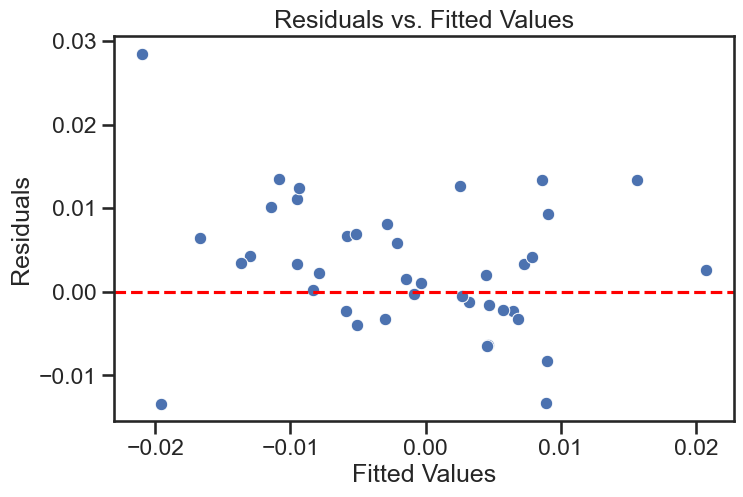

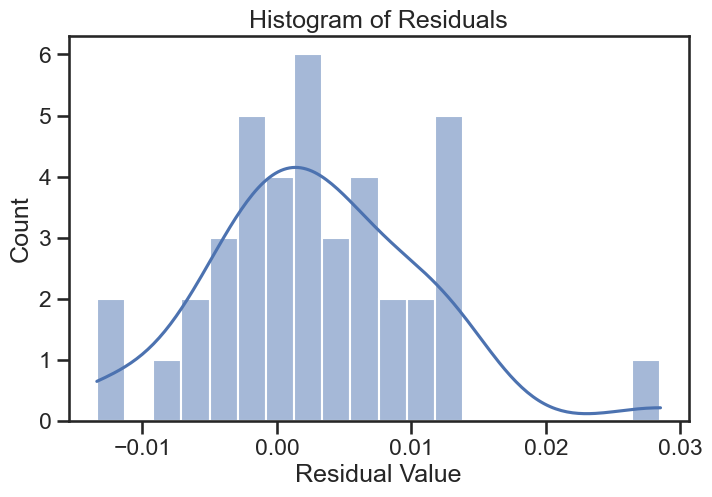

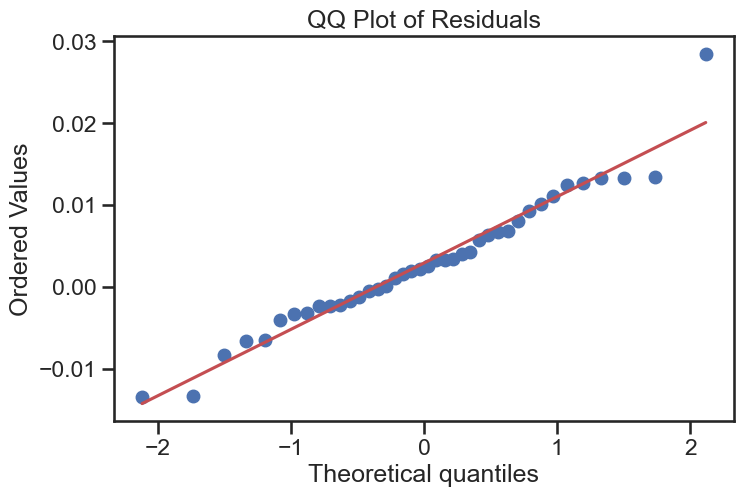

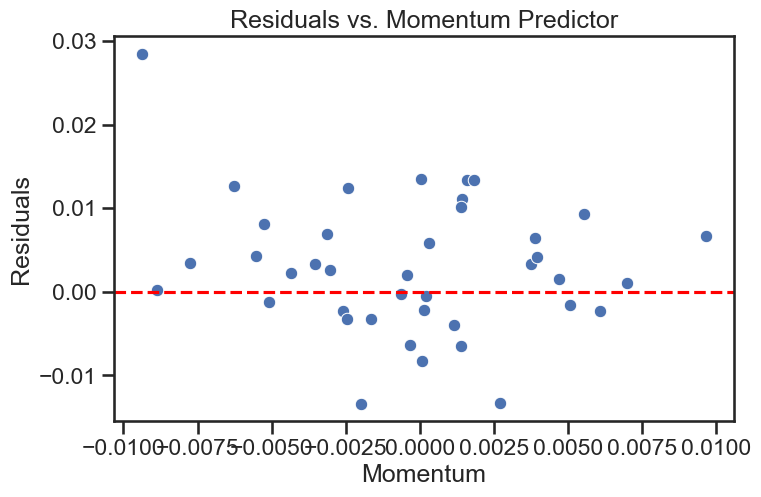

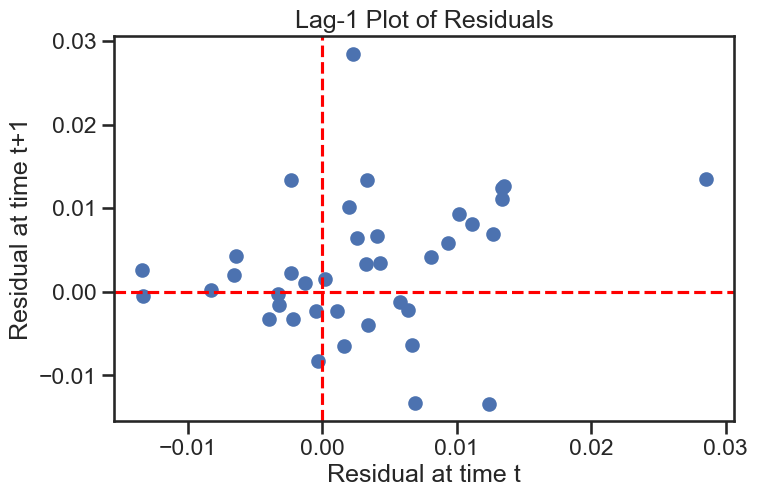

In [9]:
# Calculate residuals
resid = y_test - y_pred
fitted = y_pred

# --- Required Plots ---
# 1. Residuals vs. Fitted Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(resid, bins=20, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.show()

# 3. QQ Plot
plt.figure(figsize=(8, 5))
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


# --- Additional Plots for Rubric ---
# 4. Residuals vs. Predictor Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_test['momentum'], y=resid)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals vs. Momentum Predictor')
plt.xlabel('Momentum')
plt.ylabel('Residuals')
plt.show()

# 5. Lag Plot for Independence Check
plt.figure(figsize=(8, 5))
plt.scatter(resid[:-1], resid[1:])
plt.axhline(0, ls='--', color='red')
plt.axvline(0, ls='--', color='red')
plt.title('Lag-1 Plot of Residuals')
plt.xlabel('Residual at time t')
plt.ylabel('Residual at time t+1')
plt.show()

In [11]:
# Add the squared momentum feature
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]

# Split the new feature set
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]

# Fit the new model
lr2 = LinearRegression().fit(X2_train, y_train)

# Make predictions and calculate new metrics
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2, squared=False)
print(f'Baseline Model   --> R² = {r2:.4f} | RMSE = {rmse:.6f}')
print(f'With x^2 Feature --> R² = {r2_2:.4f} | RMSE = {rmse_2:.6f}')

Baseline Model   --> R² = 0.3677 | RMSE = 0.008470
With x^2 Feature --> R² = 0.3681 | RMSE = 0.008467


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


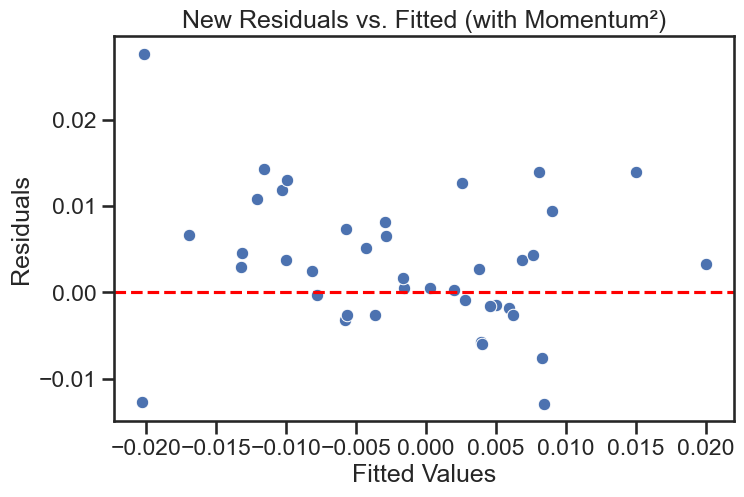

In [13]:
# Calculate and plot new residuals
resid2 = y_test - y_pred2
fitted2 = y_pred2

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted2, y=resid2)
plt.axhline(0, ls='--', color='red')
plt.title('New Residuals vs. Fitted (with Momentum²)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

**Interpretation and Conclusion**

This analysis evaluates the final, improved model which includes the momentum_sq feature.

**Linearity: Met.** The baseline model violated the linearity assumption, as shown by a distinct curve in its residual plot. Adding the momentum_sq feature corrected this issue. The new residual plot appears as a random scatter of points, indicating the linearity assumption is now satisfied.

**(Constant Variance): Violated.** The assumption of homoscedasticity is not met. The residual plot shows that the variance of the errors is not constant; it fans out in a pattern known as heteroscedasticity. This suggests the model's predictions are less reliable for certain ranges of values.

**Normality: Mostly Met.** The normality assumption appears to be satisfied. The histogram of the residuals is approximately bell-shaped, and the points on the QQ plot align closely with the reference line.

**Independence: Met.** The independence assumption is satisfied. The lag-1 plot of the residuals shows no discernible pattern, which indicates that the errors are not correlated with one another.

Which model do you trust and why?

I trust the second model more than the baseline model. It corrects the significant linearity violation found in the initial model. This improvement is confirmed by better diagnostic plots and superior performance metrics: a higher R^2 and a lower RMSE.

However, the model is not completely trustworthy. The clear presence of heteroscedasticity means that while the coefficient estimates are likely unbiased, their standard errors and confidence intervals are unreliable.

Next step you’d try:
The next step would be to address the heteroscedasticity. I would fit a Weighted Least Squares (WLS) regression. This method can correct for non-constant error variance by assigning different weights to observations, which should produce more reliable model estimates.